# Non linear Fit All profiles in All U,G,R,I Z band

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 27th 2020
- update date :


Study the relative atmosphere relative to an ideal profile in **libradtran/info_verbose/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**
- no aerosol
- pwv =4 mm
- ozone = 3000 DU
- No extinction coefficient
- airmass = 1


Fit components:

- h2o,
- o2,
- o3


The non-linear fit for the aerosols is added


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
import re
%matplotlib inline

In [2]:
from astropy.io import fits

In [3]:
from pprint import pprint # we use this to pretty print some stuff later

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

from iminuit import minimize  # has same interface as scipy.optimize.minimize

In [4]:
from datetime import datetime,date
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [5]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [6]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [7]:
import timeit

In [8]:
%load_ext autoreload
%autoreload 2

# Configuration

## Filter boudaries

In [9]:
file_wavelengthbins="data/WaveLengthBins.csv"

In [10]:
df=pd.read_csv(file_wavelengthbins,index_col=0)

In [11]:
df

,band,wl_aver,wl_wdth,wl_min,wl_max
0,u,356.0,78.0,317.0,395.0
1,g,472.0,154.0,395.0,549.0
2,r,619.0,140.0,549.0,689.0
3,i,754.0,130.0,689.0,819.0
4,z,870.5,103.0,819.0,922.0
5,y,1010.0,176.0,922.0,1098.0


In [12]:
NBFILTER=len(df)

In [13]:
FILTER_NAME=df["band"].values
WL_MIN=df["wl_min"].values
WL_MAX=df["wl_max"].values
WL_WIDTH=df["wl_wdth"].values

## Absorption pattern

In [14]:
file_abspattern="data/absorption_pattern.csv"

In [15]:
df_atm=pd.read_csv(file_abspattern,index_col=0)

In [16]:
print(df_atm.columns.tolist())

['wl', 'o2_10', 'o2_11', 'o2_12', 'o2_13', 'o2_14', 'o2_15', 'o2_16', 'o2_17', 'o2_18', 'o2_19', 'o2_20', 'o2_21', 'o2_22', 'o2_23', 'o2_24', 'o2_25', 'o3_10', 'o3_11', 'o3_12', 'o3_13', 'o3_14', 'o3_15', 'o3_16', 'o3_17', 'o3_18', 'o3_19', 'o3_20', 'o3_21', 'o3_22', 'o3_23', 'o3_24', 'o3_25', 'h2o_10', 'h2o_11', 'h2o_12', 'h2o_13', 'h2o_14', 'h2o_15', 'h2o_16', 'h2o_17', 'h2o_18', 'h2o_19', 'h2o_20', 'h2o_21', 'h2o_22', 'h2o_23', 'h2o_24', 'h2o_25', 'no2_10', 'no2_11', 'no2_12', 'no2_13', 'no2_14', 'no2_15', 'no2_16', 'no2_17', 'no2_18', 'no2_19', 'no2_20', 'no2_21', 'no2_22', 'no2_23', 'no2_24', 'no2_25']


In [17]:
rootfilename=file_abspattern.split(".")[0]

In [18]:
all_df_atm=[]
for iband in np.arange(NBFILTER):
    filename=rootfilename+"_"+FILTER_NAME[iband]+".csv"
    print("====================",filename,"=======================")
    df=pd.read_csv(filename,index_col=0)
    #df=df.reset_index(drop=True)
    all_df_atm.append(df)

==================== data/absorption_pattern_u.csv =======================
==================== data/absorption_pattern_g.csv =======================
==================== data/absorption_pattern_r.csv =======================
==================== data/absorption_pattern_i.csv =======================
==================== data/absorption_pattern_z.csv =======================
==================== data/absorption_pattern_y.csv =======================


In [19]:
#all_df_atm[0]

In [20]:
#all_df_atm[1]

In [21]:
#all_df_atm[2]

In [22]:
#all_df_atm[3]

In [23]:
#all_df_atm[4]

In [24]:
#all_df_atm[5]

## Atmospheric data

In [25]:
DATADIR="../data/atm"

## Reference atmosphere

In [26]:
data=np.loadtxt("data/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT")
wl0=data[:,0]
transm0=data[:,1]

## Decoding function

In [27]:
def GetAtmosphericProfiles(dir,wl_ref,transm_ref):
    """
    """
    atmospheric_basename_files=os.listdir(dir)
    inputfile=os.path.join(DATADIR,atmospheric_basename_files[0])
    
    idx=0
    # containers
    all_data=[]
    all_hdr=[]
    all_wl=[]
    
    # loop on files
    for file in atmospheric_basename_files:
        if re.search("^lsst_atm_10year_[0-9][0-9].*fits$",file):
            inputfile=os.path.join(DATADIR,file)
            hdu = fits.open(inputfile)
            all_hdr.append(hdu[0].header)
            all_data.append(hdu[0].data[1:,:]) # exclude first row containing wavelength
            all_wl.append(hdu[0].data[0,:])    # extract first row containg wavelength
            idx+=1
            hdu.close()
        
    data=np.vstack(all_data)               # stack vertically the data (in a signgle container) 
    hdr=all_hdr[0]
    
    #decode index from header
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    vaod=data[:,idx_out_vaod] # vertical aerosol depth
    pwv=data[:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[:,idx_out_o3]     # ozone
    cld=data[:,idx_out_cld]   # clouds (not used)
    
    
    # Extract wavelength Wavelength
    wl=all_wl[0][idx_out_res:]
    transm=data[:,idx_out_res:]
    
    if len(wl)==len(wl_ref) and wl[0]== wl_ref[0]:
        transm/=transm_ref
    else:
        print(">>>>> error reference does not match")
        
    
    return wl,transm,vaod,pwv,o3,cld
     

# Open all atmospheric files

In [28]:
wl,transm,vaod,pwv,o3,cld=GetAtmosphericProfiles(DATADIR,wl0,transm0)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


In [29]:
NBSIM=transm.shape[0]

# Distribute the relative transmission in the different filters

In [30]:
all_wl_filt=[]
all_transm_filt=[]
for iband in np.arange(NBFILTER):
    wl_indexes=np.where(np.logical_and(wl>=WL_MIN[iband],wl<=WL_MAX[iband]))[0]
    wl_filt=wl[wl_indexes]
    transm_filt=transm[:,wl_indexes]
    all_wl_filt.append(wl_filt)
    all_transm_filt.append(transm_filt)

In [31]:
#all_wl_filt[0]

In [32]:
#all_wl_filt[1]

In [33]:
#all_wl_filt[2]

In [34]:
#all_wl_filt[3]

In [35]:
#all_wl_filt[4]

In [36]:
#all_wl_filt[5]

# Preview

In [37]:
IDX_SIM=100

In [38]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

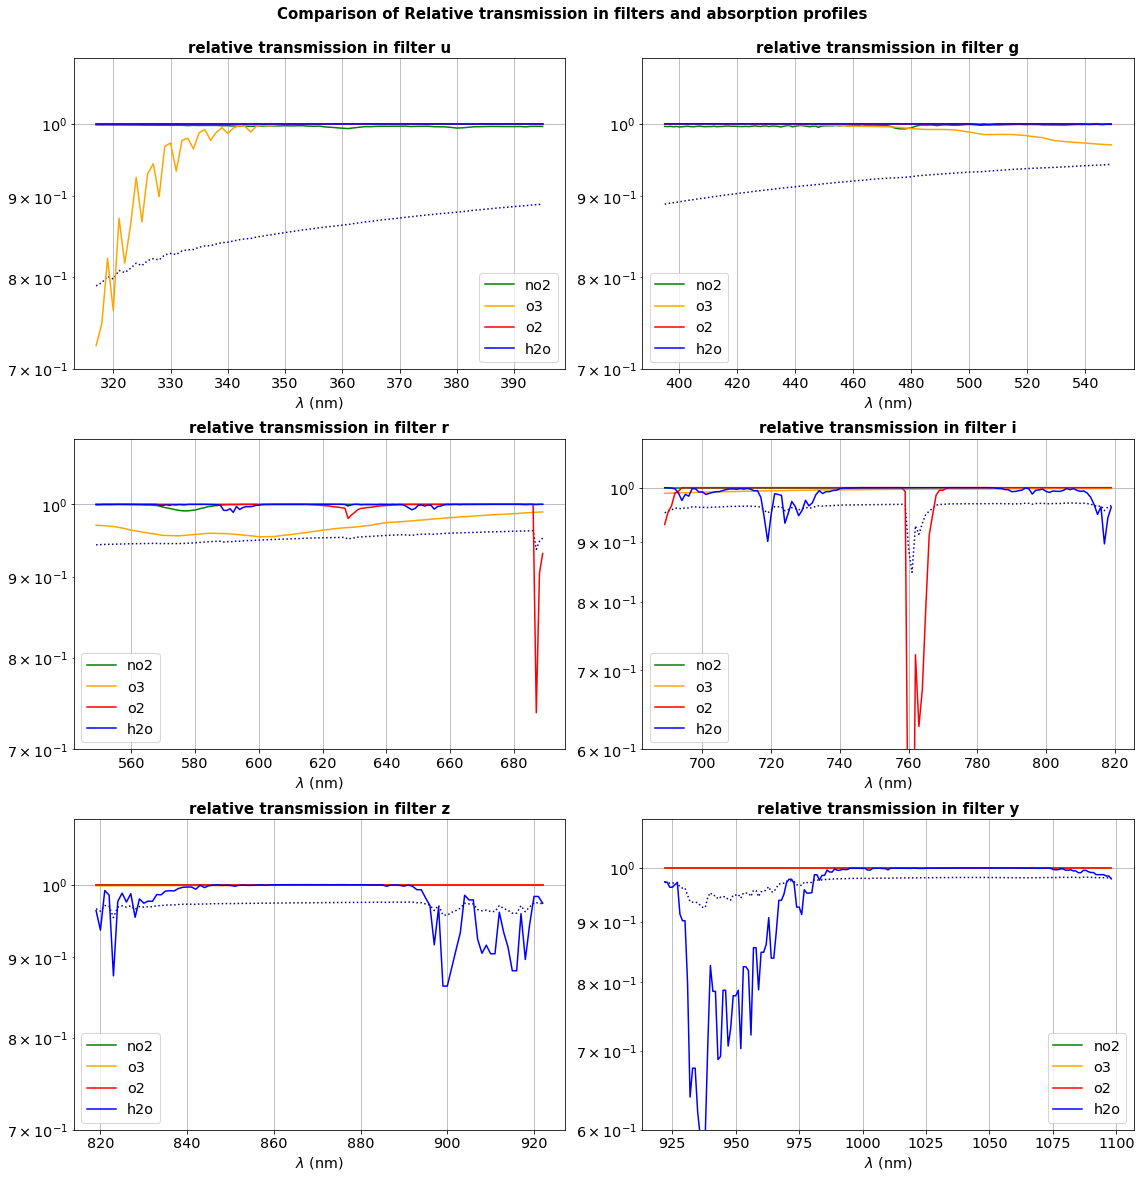

In [39]:
plt.figure(figsize=(16,16))
# loop on filter
for iband in np.arange(NBFILTER):
   
    wl=all_wl_filt[iband]
    transm=all_transm_filt[iband] 
    
    plt.subplot(3,2,iband+1)  
    # loop on simulation
    for idx in np.arange(IDX_SIM,IDX_SIM+1):
        
        colorVal=scalarMap.to_rgba(idx, alpha=1)
        plt.plot(wl,transm[idx,:],":",color=colorVal)
        
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["no2_12"],"g-",label="no2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o3_12"],"-",color="orange",label="o3")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o2_12"],"r-",label="o2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["h2o_12"],"b-",label="h2o")
            
    plt.grid(True)
    if iband<=2:
        plt.ylim(0.7,1.1)
    elif iband<=3:
        plt.ylim(0.6,1.1)
    elif iband<=4:
        plt.ylim(0.7,1.1)
    else:
        plt.ylim(0.6,1.1)
        
    plt.yscale("log")
    plt.xlabel("$\lambda$ (nm)")
    plt.legend(loc="best")
    title="relative transmission in filter {}".format(FILTER_NAME[iband])
    plt.title(title,fontweight="bold",fontsize=15)
plt.suptitle("Comparison of Relative transmission in filters and absorption profiles",fontweight="bold",fontsize=15,y=1.02)
figname=string_date+"_RelativeTransmissionFiltersAndAbsPatterns.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()  

# Fit

## Definition of the parameter structure

- params is defined as follow

### First components

- h2o
- o2
- o3

#### Continuous background

- a0 : constant grey term in Y
- a1 : slope in Z band
- a2 : slope in I band
- a3 : slope in R band
- a4 : slope in G band
- a5 : slope in U band

- b0 : linear term in Y band switched off
- b1 : second order in Z band
- b2 : second order in I band
- b3 : second order in R band
- b4 : second order in G band
- b5 : second order in U band

In [40]:
PARAMS_NAMES = ["h2o","o2","o3","a0","a1","a2","a3","a4","a5","b0","b1","b2","b3","b4","b5"]
NPARAMS =len(PARAMS_NAMES)

#### Inititalisation 

In [41]:
PARAMS0_   = np.array([1,1,1,0.1,0,0,0,0,0,0,0,0,0,0,0])
NBPARAMS = len(PARAMS0_)
PARAMSERR_ = np.ones(NBPARAMS) *0.0001

## Flags

In [42]:
FLAG_FIT_U = True
FLAG_FIT_G = True
FLAG_FIT_R = True
FLAG_FIT_I = True
FLAG_FIT_Z = True
FLAG_FIT_Y = True

In [43]:
FLAGS_FIT_SEL = np.array([FLAG_FIT_Y,FLAG_FIT_Z,FLAG_FIT_I,FLAG_FIT_R,FLAG_FIT_G,FLAG_FIT_U])
FLAGS_FIT_NUM = np.array([5,4,3,2,1,0])

## Global variables

In [44]:
IBAND_     = 5
DATA_      = all_transm_filt[iband][IDX_SIM,:]
WL_        = all_wl_filt[iband]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values , all_df_atm[iband]["o3_12"].values] # only one pattern

## Fit function

In [45]:
def SetGlobals(iband):
    """
    Defines global variables used by fit function:
    
    DATA_     :  transmission ratio data
    PATTERNS_ :  array of absorption pattern
    WL_       :  wavelength
    
    """
    global IBAND_       # Current band 
    global DATA_        # transmission ratio data
    global PATTERNS_    # array of absorption pattern
    global WL_          # wavelength
    
    IBAND_     = iband
    DATA_      = all_transm_filt[iband][IDX_SIM,:]
    WL_        = all_wl_filt[iband]
    PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values , all_df_atm[iband]["o3_12"].values] # only one pattern


In [46]:
def ContinuousComponent(x,cparams):
    """
    ContinuousComponent(x,iband,cparams):
    
    input argument :
     x     : wavelength, can be a numpy array
    
    """
    
    a0=cparams[0]  # grey term
    a1=cparams[1]  # slope in Z
    a2=cparams[2]  # slope in I
    a3=cparams[3]  # slope in R
    a4=cparams[4]  # slope in G
    a5=cparams[5]  # slope in U
    
    b0=cparams[6]  # slope in Z
    b1=cparams[7]  # slope in Z
    b2=cparams[8]  # slope in I
    b3=cparams[9]  # slope in R
    b4=cparams[10]  # slope in G
    b5=cparams[11]  # slope in U
    
    x0=WL_MIN[0]   # lower bound in U
    x1=WL_MIN[1]   # lower bound in G
    x2=WL_MIN[2]   # lower bound in R
    x3=WL_MIN[3]   # lower bound in I
    x4=WL_MIN[4]   # lower bound in Z
    x5=WL_MIN[5]   # lower bound in Y
    x6=WL_MAX[5]   # upper bound in Y
    
    w0=x6-x5       # width of Y
    w1=x5-x4       # width of Z 
    w2=x4-x3       # width of I
    w3=x3-x2       # width of R
    w4=x2-x1       # width of G
    w5=x1-x0       # width of U
    
    
    if   IBAND_ == 5 :    # Y band
        y = a0 * np.ones(len(x)) +b0*(x-x5)   
    elif IBAND_ == 4 : # Z band
        y = a0 + a1*(x-x5) + b1*(x-x5)**2
    elif IBAND_ == 3 : # I band
        y = a0 - a1*w1 +b1*w1**2 + a2*(x-x4) +b2*(x-x4)**2
    elif IBAND_ == 2 : # R band
        y = a0 - a1*w1 +b1*w1**2 - a2*w2 + b2*w2**2 + a3*(x-x3) + b3*(x-x3)**2
    elif IBAND_ == 1 : # R band
        y = a0 - a1*w1 +b1*w1**2 - a2*w2 + b2*w2**2 - a3*w3 + b3*w3**2 + a4*(x-x2) + b4*(x-x2)**2
    elif IBAND_ == 0 : # R band
        y = a0 - a1*w1 +b1*w1**2 - a2*w2 + b2*w2**2 - a3*w3 + b3*w3**2 - a4*w4 + b4*w4**2 + a5*(x-x1) + b5*(x-x1)**2
    
    return y

In [47]:
def ModelInBand(params):
    """
    ModelInBand(params) : compute the atmospheric model from the parameters
    This function is called by the function Chi2OneFiltAbsPatternAndGrey_np(params)
    
    input:
       params : parameters of the fit
       
    output:
      model : array of the model values, each value corresponding to the value at a given wavelength
    
    """
    NBPATTERNS=len(PATTERNS_)    # number of absorption patterns in the model
    CPARAMS=params[NBPATTERNS:]  # parameters for the continuous model
    
    
    # create the model, one value per wavelength in the band (numpy array)
    # add the continuous model    
    model   = ContinuousComponent(WL_,CPARAMS)
    
    # add component one by one
    for idx_component in np.arange(NBPATTERNS):
        model  = model + params[idx_component]*PATTERNS_[idx_component]
         
    return model  

In [48]:
def Chi2OneFiltAbsPatternAndGrey_np(params):
    """
    Chi2(data,patterns,params) compute the chi2 in one band
    
    The format is complient with iMinuit
    
    External DATA_,PATTERNS_
    
    
    - data: one numpy array of data (ratio for each wavelength bin)
    - patterns : list of arrays of absorption patterns
    - params : array of values one grey plus one factor for each of the pattern 
    
    The data and the patterns much match in size
    
    Compute the chi2: 
    
    Note no error is probided at the moment
    
    """
    
    global DATA_
     
    model = ModelInBand(params)       # call the calculation of the model for that parameter set
    
    assert len(DATA_) == len(model)   # check data and model have the same wavelength size
   
    diff=DATA_- model # difference
        
    diff2=diff**2    # compute the difference 
    chi2=diff2.sum() # compute the sum
    
    return chi2
    

## Check the Fit in all bands for one simulation as example

In [49]:
# initialisation
h2o_0  = 1.0
o2_0   = 1.
o3_0   = 1.
a0_0   = 0

In [50]:
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values, all_df_atm[iband]["o3_12"].values ] # only one pattern
PARAMS0_   = np.array([h2o_0,o2_0,o3_0, a0_0,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
PARAMSERR_ = np.ones(PARAMS0_.shape)*0.00001
FIXPARAMS_ = (False,False,False,False,False,False,False,False,False,True,False,False,False,False,False)

In [51]:
FLAG_FIT_U = True
FLAG_FIT_G = True
FLAG_FIT_R = True
FLAG_FIT_I = True
FLAG_FIT_Z = True
FLAG_FIT_Y = True

In [52]:
FLAGS_FIT_SEL = np.array([FLAG_FIT_Y,FLAG_FIT_Z,FLAG_FIT_I,FLAG_FIT_R,FLAG_FIT_G,FLAG_FIT_U])
FLAGS_FIT_NUM = np.array([5,4,3,2,1,0])

In [53]:
def Chi2ManyFiltAbsPatternAndGrey_np(params):
    """
    Chi2(data,patterns,params) compute the chi2 in one band
    
    The format is complient with iMinuit
    
    External DATA_,PATTERNS_
    
    
    - data: one numpy array of data (ratio for each wavelength bin)
    - patterns : list of arrays of absorption patterns
    - params : array of values one grey plus one factor for each of the pattern 
    
    The data and the patterns much match in size
    
    Compute the chi2: 
    
    Note no error is probided at the moment
    
    """
    # first band
       
    global DATA_
    global PATTERNS_
    
    chi2=0
    
    # loop on bands starting by Y only for validated 
    for idx,iband in np.ndenumerate(FLAGS_FIT_NUM):
        
        if FLAGS_FIT_SEL[idx[0]]:  
            
            SetGlobals(iband)                                 # set global values IBAND_, WL_, DATA_ and PATTERN_       
            chi2+=Chi2OneFiltAbsPatternAndGrey_np(params)     # Compute chi2 for that filter band
            
    return chi2
    

In [54]:
m = Minuit.from_array_func(Chi2ManyFiltAbsPatternAndGrey_np, PARAMS0_, error=PARAMSERR_, fix=FIXPARAMS_ ,name = ("h2o","o2","o3","a0","a1","a2","a3","a4","a5","b0","b1","b2","b3","b4","b5" ),errordef=1)

In [55]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.002368                |     Ncalls=587 (587 total)     |
| EDM = 1.69e-13 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | h2o  |    0.1    |    0.7    |            |            |         |         |       |
| 1 | o2   |    0.2    |    1.0    |            |            |         |         |       |
| 2 | o3   |    0.1    |    3.5    |            |            |         |         |       |
| 3 | a0   |     1     |     4     |            |            |         |         |       |
| 4 | a1   |   0.000   |   0.007   |            |            |         |         |       |
| 5 | a2   |   0.000   |   0.007   |            |            |         |         |       |
| 6 | a3   |   0.000   |   0.006   |            |            |         |         |       |
| 7 | a4   |   0.000   |   0.006   |            |            |         |         |       |
| 8 | a5   |   0.001   |   0.017   |            |            |         |         |       |
| 9 | b0   |     0     |  0.01e-3  |            |            |         |         |  yes  |
| 10| b1   |     0     |  0.07e-3  |            |            |         |         |       |
| 11| b2   |    -0     |  0.05e-3  |            |            |         |         |       |
| 12| b3   |    -0     |  0.04e-3  |            |            |         |         |       |
| 13| b4   |    -0     |  0.04e-3  |            |            |         |         |       |
| 14| b5   |    -0     |  0.3e-3   |            |            |         |         |       |
------------------------------------------------------------------------------------------

### Extract the fitted parameters

In [56]:
h2o_fit=m.values[0]
o2_fit=m.values[1]
o3_fit=m.values[2]
grey_fit=m.values[3]

h2o_fit_err=m.errors[0]
o2_fit_err=m.errors[1]
o3_fit_err=m.errors[2]
grey_fit_err=m.errors[3]

#### Get the parameters in a numpy array

In [57]:
params=m.np_values()
paramserr=m.np_errors()

## Plot

Text(0.5, 1.02, 'fit in R,I,Z,Y band h2o=0.141+/- 0.719 , o2=0.152+/- 0.950 , o3=0.089+/- 3.531 ')

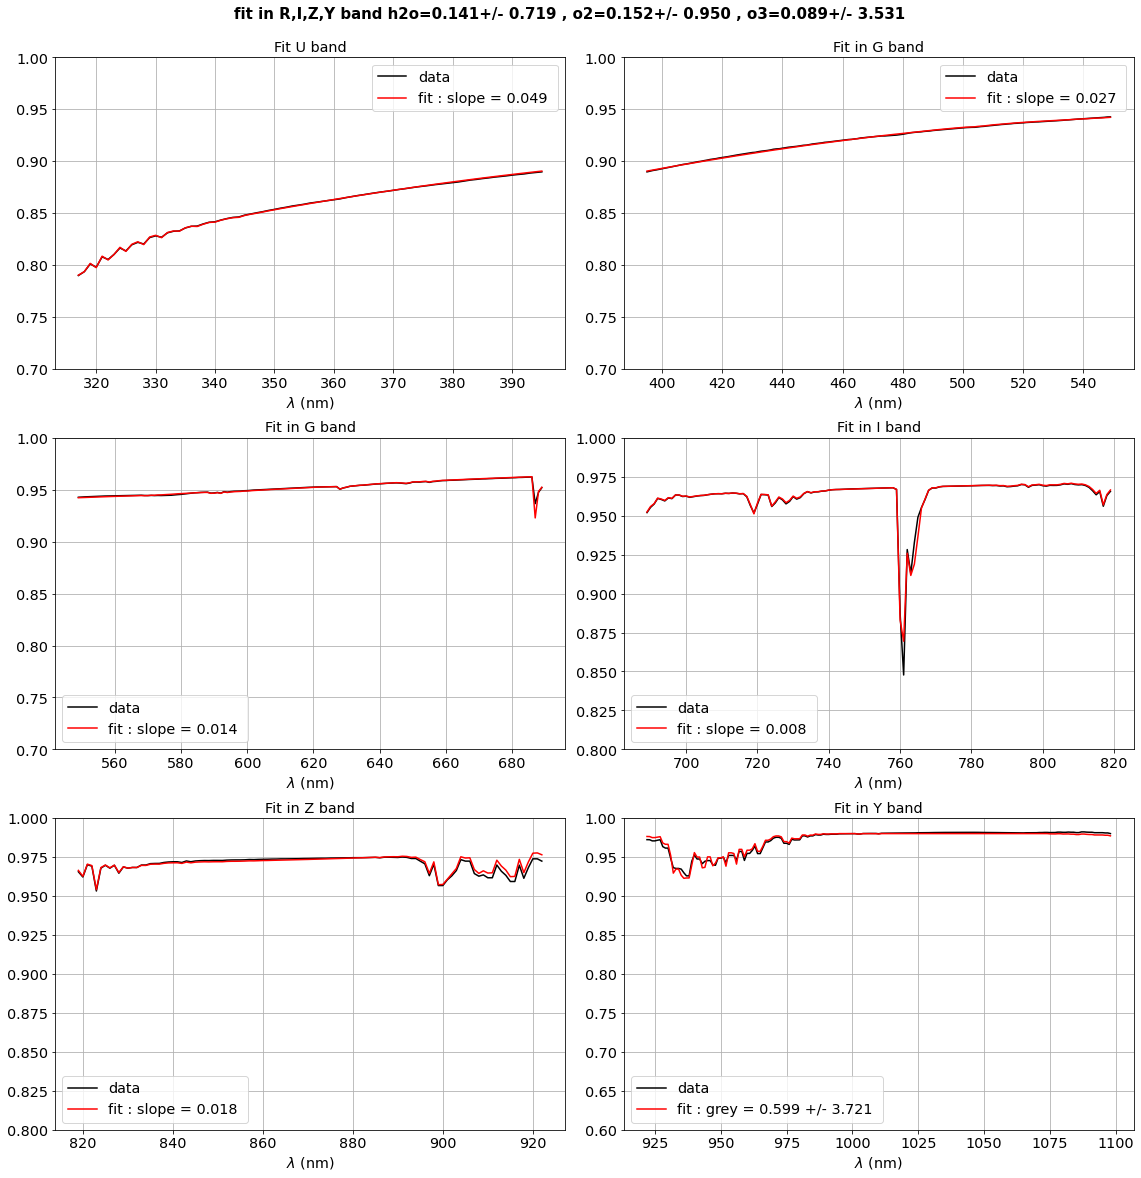

In [58]:
plt.figure(figsize=(16,16))
#---------------------------------
#----------------------------------

plt.subplot(3,2,1)
iband=0
SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[8]*WL_WIDTH[0])

plt.title("Fit U band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#------------------------------------
#------------------------------------

plt.subplot(3,2,2)
iband=1

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[7]*WL_WIDTH[1])

plt.title("Fit in G band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#----------------------------------
#----------------------------------

plt.subplot(3,2,3)
iband=2

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[6]*WL_WIDTH[2])


plt.title("Fit in G band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,"r-",label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-------------------------------------
#-------------------------------------

plt.subplot(3,2,4)
iband=3

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[5]*WL_WIDTH[3])


plt.title("Fit in I band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-------------------------------
#-------------------------------

plt.subplot(3,2,5)
iband=4

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[4]*WL_WIDTH[4])


plt.title("Fit in Z band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)
    
#-------------------------------
#-------------------------------

plt.subplot(3,2,6)
iband=5

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : grey = {:3.3f} +/- {:3.3f} ".format(grey_fit,grey_fit_err)

plt.title("Fit in Y band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)
    
#----------------------------    
plt.tight_layout()


suptitle="fit in R,I,Z,Y band h2o={:1.3f}+/- {:1.3f} , o2={:1.3f}+/- {:1.3f} , o3={:1.3f}+/- {:1.3f} ".format(h2o_fit,h2o_fit_err,o2_fit,o2_fit_err,o3_fit,o3_fit_err)
plt.suptitle(suptitle,y=1.02,fontweight="bold",fontsize=15)

## Result of that fit

Text(0.5, 1.0, 'Atmospheric transmission difference')

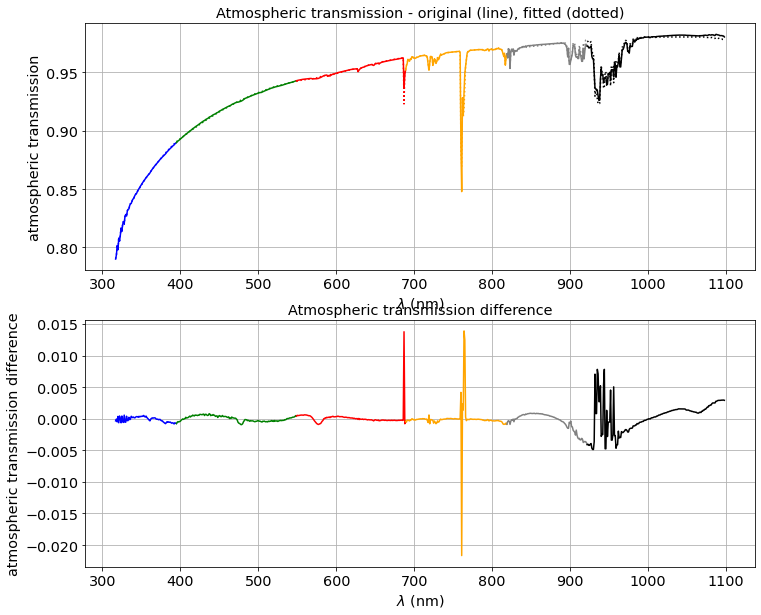

In [59]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
all_color = ["b","g","r","orange","grey","k"]
for iband in np.arange(NBFILTER):
     
    SetGlobals(iband)
    MODELS = ModelInBand(params)
      
    plt.plot(WL_,DATA_,"-",color=all_color[iband])
    plt.plot(WL_,MODELS,":",color=all_color[iband])
      
plt.grid()
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("atmospheric transmission")
plt.title("Atmospheric transmission - original (line), fitted (dotted)")

plt.subplot(2,1,2)
for iband in np.arange(NBFILTER):
     
    SetGlobals(iband)
    MODELS = ModelInBand(params)
      
    plt.plot(WL_,DATA_-MODELS,"-",color=all_color[iband])
      
plt.grid()
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("atmospheric transmission difference")
plt.title("Atmospheric transmission difference")



# Fit now on all simulation

## Output file

In [60]:
output_file='lsst_atm_10year_fittedabspatternsandsims.fits'

## Concatenation function

In [61]:
def GetReconstructedProfile(params):
    """
        GetReconstructedProfile(params) : This function pack the fit result in different bands in a single arrays
    
    """
    
    all_model_wl=[]
    all_model_transmratio = []
    all_data_transmratio = []
    
    for iband in np.arange(NBFILTER):
     
        SetGlobals(iband)
        MODELS = ModelInBand(params)
        
        if iband<5:
            all_model_wl.append(WL_[:-1])
            all_model_transmratio.append(MODELS[:-1])
            all_data_transmratio.append(DATA_[:-1])
        else:
            all_model_wl.append(WL_)
            all_model_transmratio.append(MODELS)
            all_data_transmratio.append(DATA_)
    
    all_model_wl = np.array(all_model_wl)
    all_model_transmratio = np.array(all_model_transmratio)
    all_data_transmratio  = np.array(all_data_transmratio)
    
    return np.concatenate(all_model_wl), np.concatenate(all_model_transmratio), np.concatenate(all_data_transmratio)
    

In [62]:
thewl,themodelr,thedatar=GetReconstructedProfile(params)

In [63]:
NWL=len(thewl)

## Prepare the numpy array (image) that will be used as the container for the fit

In [64]:
#PARAMS_NAMES = ["h2o","o2","o3","a0","a1","a2","a3","a4","a5","b0","b1","b2","b3","b4","b5"]
#NPARAMS =len(PARAMS_NAMES)

In [65]:
#vaod,pwv,o3,cld
NBPARAMS_SIM=4

In [66]:
NBROW=NBSIM+2                      # all simulations and the wavelength row + row of reference transmission
NBCOL=NPARAMS+NWL+NBPARAMS_SIM+NWL # parameters and twice the wl length (reconstructed, simulated)

In [67]:
pto_FITPARAM  = 0                          # pointer to fitted parameters
pto_FITDATA   = NPARAMS                    # pointer to fitted data (output of this code)
pto_SIMPARAM  = NPARAMS+NWL                # pointer to simulated parameters  (vaod,pwv,o3,cld)
pto_SIMDATA   = NPARAMS+NWL+NBPARAMS_SIM   # pointer to simulated data (input of this code)
pto_ENDDATA   = NBCOL

In [68]:
data_out=np.zeros((NBROW,NBCOL))          # create the output container

## Prepare the fitted parameter string

In [69]:
STR_COL=[]
for name in PARAMS_NAMES:
    STR_COL.append("PAR_"+ name.upper())

## Save some information

### Save wavelength

In [70]:
data_out[0,pto_FITDATA:pto_SIMPARAM]=thewl
data_out[0,pto_SIMDATA:]=thewl

### Save simulated parameters

In [71]:
data_out[2:,pto_SIMPARAM]   = vaod
data_out[2:,pto_SIMPARAM+1] = pwv
data_out[2:,pto_SIMPARAM+2] = o3
data_out[2:,pto_SIMPARAM+3] = cld

### Save the reference atmospheric transmission (no aerosol, pwv=4 , o3=300)

#### Must reshape wl0 and transm0

indeed only wavelength in LSST filter ranges has been kept

In [72]:
wl0_indexes=np.where(np.logical_and(wl0>=thewl.min(),wl0<=thewl.max()) )[0]

In [73]:
wl0_sel=wl0[wl0_indexes]
transm0_sel=transm0[wl0_indexes]

In [74]:
data_out[1,pto_SIMDATA:]=transm0_sel

## Loop on all all simulations

In [ ]:
# Loop on simulations
start = timeit.default_timer()
nbyear=0
for IDX_SIM in np.arange(NBSIM):
#for IDX_SIM in np.arange(10):    
    # prepate the fit
    m = Minuit.from_array_func(Chi2ManyFiltAbsPatternAndGrey_np, PARAMS0_, error=PARAMSERR_, fix=FIXPARAMS_ ,name = ("h2o","o2","o3","a0","a1","a2","a3","a4","a5","b0","b1","b2","b3","b4","b5" ),errordef=1)
   
    # minimisation
    m.migrad()
    
    # extract fitted parameters
    params=m.np_values()
    paramserr=m.np_errors()
    
    # extract concatenated profiles
    all_model_wl, all_model_transmratio, all_data_transmratio=GetReconstructedProfile(params)
    
    # save results in the image array
    data_out[IDX_SIM+2,pto_FITPARAM:pto_FITDATA] = params
    data_out[IDX_SIM+2,pto_FITDATA:pto_SIMPARAM] = all_model_transmratio
    data_out[IDX_SIM+2,pto_SIMDATA:]             = all_data_transmratio
    
    # info on simulation time
    if IDX_SIM%365 == 0 and IDX_SIM>0 :
        nbyear+=1
        stop = timeit.default_timer()
        tim=stop-start
        print("nbsim = {}, year = {}, time = {:6.2f} s, fit-rate = {:3.4f} s/simu".format(IDX_SIM,nbyear,tim,tim/IDX_SIM))
        

nbsim = 365, year = 1, time =  92.85 s, fit-rate = 0.2544 s/simu
nbsim = 730, year = 2, time = 184.48 s, fit-rate = 0.2527 s/simu


## Check the fit results by plotting the relative profiles and the reference profile

In [ ]:
idx0=2  # take one simulation among the 365 x 10 

In [ ]:
plt.plot(data_out[0,pto_SIMDATA:],data_out[idx0,pto_SIMDATA:],"b-",label="simulated relative profile")
plt.plot(data_out[0,pto_FITDATA:pto_SIMPARAM],data_out[idx0,pto_FITDATA:pto_SIMPARAM],"r-",label="fitted relative profile")
plt.plot(data_out[0,pto_SIMDATA:],data_out[1,pto_SIMDATA:],"g:",label="whole reference profile")
plt.grid()
plt.title("example of fitted - relative simulated profile and reference transmission profile")
plt.legend()

In [ ]:
with np.printoptions(precision=3, suppress=True):
    print(data_out[:11,0:NBPARAMS])

In [ ]:
# uncomment if want to see the results : comment to save space
#plt.imshow(data_out[2:,:],origin="lower",cmap='jet')

## Save results in ouput file

- output in a fit image file

### Create the Fits header

In [ ]:
hdr = fits.Header()

# general info
hdr['NBSIM']   = NBSIM                      # number of original simulations
hdr['NPARAMS'] = NPARAMS                    # number of parameters used in the current fit
hdr['NWL']     = NWL                        # total number of wavelength (here every one nm)

# parameter index in the image
hdr["PFITPAR"] = pto_FITPARAM               # pointer where the fitted parameter can be found (along X or col)

for idx,strcol in np.ndenumerate(STR_COL):  # Name of the fitted parameters
    hdr[strcol]=idx[0]
    
# parameters from the input simulation
hdr["NSIMPAR"]   = NBPARAMS_SIM             # number of simulation parameters : vaod,pwv,o3,cld
hdr["PSIMPAR"]   = pto_SIMPARAM             # pointer where the fitted parameter can be found (along X or col)

hdr["IDX_VAOD"]  = pto_SIMPARAM
hdr["IDX_H20"]   = pto_SIMPARAM +1
hdr["IDX_O3"]    = pto_SIMPARAM +2 
hdr["IDX_CLD"]   = pto_SIMPARAM +3 


# pointer on fitted data and simulated
hdr["DATAFIT"] = pto_FITDATA                # pointer where the fitted data can be found (along X or col)
hdr["DATASIM"] = pto_SIMDATA                # pointer where the simulated data can be found (along X or col)
hdr["DATAEND"] = pto_ENDDATA                # pointer to the end of data

In [ ]:
hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu.writeto(output_file,overwrite=True)